In [1]:
import csv
import numpy as np

images, labels = [], []

with open('train.csv') as train_file:
    # Skip first line.
    train_file.readline()
    
    csv_train_file = csv.reader(train_file, delimiter=',')
    for row in csv_train_file:
        labels.append(row[0])
        images.append(np.array(row[1:], dtype=float))

In [2]:
##############################################################
#           Part One: Preprocess Data 1) Explore
##############################################################

Printing sample with label 8.


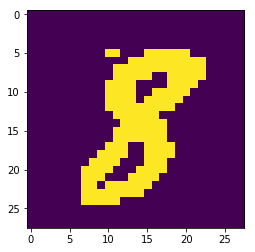

In [3]:
sample_index = 20

import matplotlib
from matplotlib import pyplot as plt

sample, label = images[sample_index], labels[sample_index]
plt.imshow(np.reshape(sample, (28, 28)), norm=matplotlib.colors.NoNorm())

print("Printing sample with label %s." % (label))
plt.show()

Printing sample with normalzied pixels.


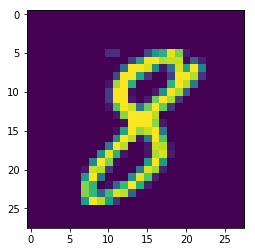

In [4]:
# Normalizing a sample to scale of (0, 1)

PIXEL_SCALE = 255
normalized_sample = sample / PIXEL_SCALE
plt.imshow(np.reshape(normalized_sample, (28, 28)), norm=matplotlib.colors.NoNorm())
print("Printing sample with normalzied pixels.")
plt.show()

In [5]:
normalized_images = [image / PIXEL_SCALE for image in images]

In [6]:
################################################################
#           Part One: Preprocess Data 2) Split Data Set
################################################################

In [7]:
# One hot encoding labels.
def one_hot_label(label):
    one_hot_coded = np.zeros(10)
    one_hot_coded[int(label)] = 1
    return np.array(one_hot_coded)

In [8]:
import random

combined = list(zip(images, labels))
random.shuffle(combined)
images[:], labels[:] = zip(*combined)

validation_size = int(len(images) / 10)

validate_images = [np.array(image).reshape((28, 28, 1)) for image in images[:validation_size]]
validate_labels = [one_hot_label(label) for label in labels[:validation_size]]

images = images[validation_size:]
labels = labels[validation_size:]


In [9]:
import tensorflow as tf

/Users/Carter/anaconda2/envs/dlnd/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
################################################################
#                Part Two: (1) Create Tensor
################################################################

In [11]:
def conv_net_input(input_shape):
    tensor_shape = [None] + list(input_shape)
    return tf.placeholder(tf.float32, shape=tensor_shape, name='conv_input')

def conv_net_label(label_shape):
    label_shape = [None, label_shape]
    return tf.placeholder(tf.float32, shape=label_shape, name='conv_label')

def conv_net_dropout_prob():
    return tf.placeholder(tf.float32, name='dropout_prob')

In [12]:
##############################################################
#                Part Two: (2) Create Layer
##############################################################

In [13]:
def conv2d(input_tensor, kernel_depth=1, output_dim=32, k_size=3, padding='valid'):
    """
    :param input_tensor: input tensor, should be reshaped to 2D
    :param output_dim: output dimension, e.g. 32, 64, etc. 
    :param kernel_size: kernel size, 3, 5, etc.
    """
    
    print(input_tensor.get_shape().as_list())
    
    conv_layer = tf.layers.conv2d(input_tensor,
                                  output_dim,
                                  k_size,
                                  padding=padding,
                                  activation=tf.nn.relu)
    
    return conv_layer

In [14]:
def max_pool(input_tensor, pool_ksize, pool_strides, padding='valid'):
    return tf.layers.max_pooling2d(
        input_tensor,
        pool_ksize,
        pool_strides,
        padding
    )

In [15]:
from functools import reduce

def flatten(input_tensor):
    image_dimension = reduce(lambda a,b: a*b, input_tensor.get_shape().as_list()[1:])    
    return tf.reshape(input_tensor, [-1, image_dimension])

In [16]:
def fully_connected_with_dropout(input_tensor, output_dim, dropout):    
    fully_connected = tf.layers.dense(
        input_tensor,
        output_dim,
    )
    
    dropout_layer = tf.layers.dropout(inputs=fully_connected, rate=dropout)    
    
    return dropout_layer

In [17]:
def output_layer(input_tensor, output_dim):    
    return tf.layers.dense(
        input_tensor,
        output_dim,
    )

In [18]:
class BatchLoader:
    
    def __init__(self, images=[], label=[]):
        self.images = images
        self.labels = labels
        self.offset = 0
        
    def load_batch_image(self, batch_size):
        i = self.offset
        image_batch = self.images[i: i + batch_size]
        image_batch = [image.reshape((28, 28, 1)) for image in image_batch]       
        self.offset += batch_size
        return image_batch
        
    def load_batch(self, batch_size):        
        i = self.offset
        image_batch = self.images[i: i + batch_size]
        image_batch = [image.reshape((28, 28, 1)) for image in image_batch]
                
        label_batch = self.labels[i: i + batch_size]
        label_batch = [one_hot_label(label) for label in label_batch]
        self.offset += batch_size
                
        return image_batch, label_batch
        
    def reset(self):
        self.offset = 0

In [19]:
##############################################################
#                Part Two: (3) Create Model
##############################################################

In [23]:

def conv_net(image, dropout_prob):
    """
    :param image: input image tensor.
    :dropout_prob: drop out probability.
    """
    # convolution - max pooling layer 1
    conv_layer = conv2d(image, kernel_depth=1, output_dim=16, k_size=3)
    mp_layer = max_pool(conv_layer, 2, 2)
    
    # convolution - max pooling layer 2
    conv_layer = conv2d(mp_layer, kernel_depth=16, output_dim=32, k_size=3)
    mp_layer = max_pool(conv_layer, 2, 2)
    
    # convolution - max pooling layer 3
    conv_layer = conv2d(mp_layer, kernel_depth=32, output_dim=64, k_size=3)
    mp_layer = max_pool(conv_layer, 2, 2)
    
    conv_layer = conv2d(mp_layer, kernel_depth=32, output_dim=64, k_size=1)
    mp_layer = max_pool(conv_layer, 1, 1)
    
    flat = flatten(mp_layer)
    
    fully_conn = fully_connected_with_dropout(flat, 96, dropout_prob) 
    logits = output_layer(fully_conn, 10)
    
    return logits

In [24]:
##############################################################
#                Part Three: Define Loss & Accuracy
##############################################################

In [25]:
tf.reset_default_graph()

image_tensor = conv_net_input((28, 28, 1))
label_tensor = conv_net_label(10)
dropout_prob_tensor = conv_net_dropout_prob()

# Module

logits = conv_net(image_tensor, dropout_prob_tensor)
logits = tf.identity(logits, name='logits')

# Loss & Optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=label_tensor))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(loss)

correct_pred = tf.equal(tf.argmax(logits, axis=1), tf.argmax(label_tensor, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

[None, 28, 28, 1]
[None, 13, 13, 16]
[None, 5, 5, 32]
[None, 1, 1, 64]


In [26]:
from functools import reduce
reduce((lambda a,b: a*b), [1,2], 1)

2

In [27]:
def print_stats(session,
                image_batch,
                label_batch,
                validation_image_batch,
                validation_label_batch,
                t_loss_seq,
                v_loss_seq
               ):
    
    t_loss = session.run(loss, feed_dict={
        image_tensor : image_batch,
        label_tensor : label_batch,
        dropout_prob_tensor : 0.0
    })
    
    t_loss_seq.append(t_loss)

    t_accuracy = session.run(accuracy, feed_dict={
        image_tensor : image_batch,
        label_tensor : label_batch,
        dropout_prob_tensor : 0.0     
    })
    
    v_loss = session.run(loss, feed_dict={
        image_tensor : validation_image_batch,
        label_tensor : validation_label_batch,
        dropout_prob_tensor : 0.0
    })
    
    v_loss_seq.append(v_loss)
    
    v_accuracy = session.run(accuracy, feed_dict={
        image_tensor : validation_image_batch,
        label_tensor : validation_label_batch,
        dropout_prob_tensor : 0.0     
    })
        
    print('Training loss: ', t_loss)
    print('Validation loss: ', v_loss)

    print('Training accuracy: ', t_accuracy)
    print('Validation accuracy: ', v_accuracy)



In [28]:
##############################################################
#                Part Four: Training
##############################################################

In [29]:
from matplotlib import pyplot as plt

In [30]:
def train_model(session, optimizer, image_batch, label_batch, dropout_prob):
    
#     print('image_batch shape: ', len(image_batch))
#     print('label_batch shape: ', len(label_batch))
#     print('dropout_prob shape: ', dropout_prob)
    
    session.run(
        optimizer,
        feed_dict={
            image_tensor : image_batch,
            label_tensor : label_batch,
            dropout_prob_tensor : dropout_prob
        }
    )

In [31]:
save_model_path = './kaggle_digit'

def run_model(epochs, images, labels, batch_size, dropout_prob):
    
    t_loss_seq, v_loss_seq = [], []    
    
    with tf.Session() as session:
        
        # Initializing the variables
        session.run(tf.global_variables_initializer())
    
        # Prepare batches for images & labels
        loader = BatchLoader(images, labels)
    
        for epoch in range(epochs):
            loader.reset()
            
            count = 0
            
            while True:                
                image_batch, label_batch = loader.load_batch(batch_size)
                count += 1
                
                # Process each batch.
                if len(image_batch) != 0  and len(label_batch) != 0:                     
                    train_model(session, optimizer, image_batch, label_batch, dropout_prob)
                    
                    # Print stats every 7 epochs.
                    if count % 7 == 0:
                        print('===============epoch: ', epoch, '=================')
                        print_stats(session, image_batch, label_batch, 
                                    validate_images, validate_labels,
                                    t_loss_seq, v_loss_seq)
                        
                        ## Plot out training loss vs validation loss.
                        time_series = range(len(t_loss_seq))
                        plt.plot(time_series, t_loss_seq)
                        plt.plot(time_series, v_loss_seq)
                        plt.legend(['training_loss', 'validation_loss'])

                        plt.show()
                else:
                    break
                    
        saver = tf.train.Saver()
        save_path = saver.save(session, save_model_path)
                    


===============epoch:  0 =================
Training loss:  12.1771
Validation loss:  12.3814
Training accuracy:  0.158333
Validation accuracy:  0.147619


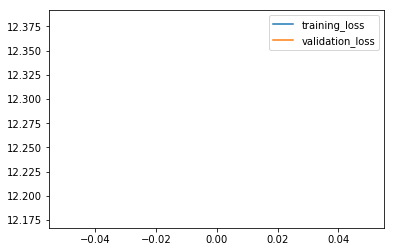

===============epoch:  0 =================
Training loss:  7.68881
Validation loss:  7.75063
Training accuracy:  0.255
Validation accuracy:  0.241667


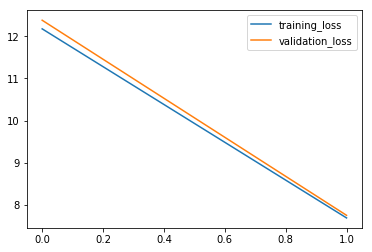

===============epoch:  0 =================
Training loss:  3.64751
Validation loss:  3.763
Training accuracy:  0.346667
Validation accuracy:  0.355476


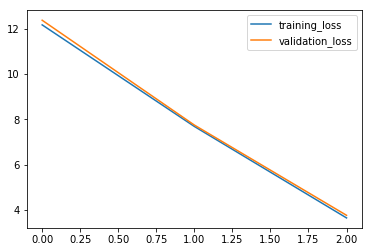

===============epoch:  0 =================
Training loss:  2.68151
Validation loss:  2.68966
Training accuracy:  0.335
Validation accuracy:  0.360238


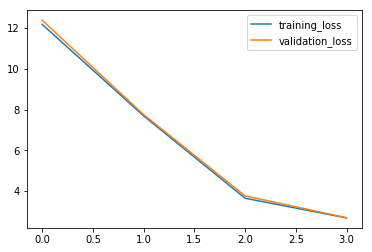

===============epoch:  0 =================
Training loss:  2.05326
Validation loss:  2.04416
Training accuracy:  0.465
Validation accuracy:  0.45


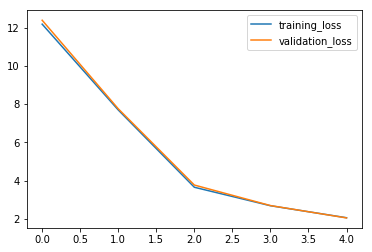

===============epoch:  0 =================
Training loss:  1.68668
Validation loss:  1.67361
Training accuracy:  0.536667
Validation accuracy:  0.524524


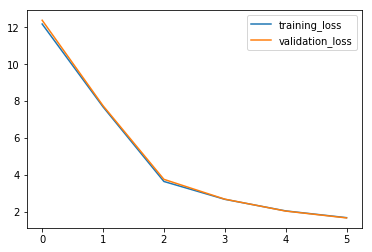

===============epoch:  0 =================
Training loss:  1.57721
Validation loss:  1.43122
Training accuracy:  0.59
Validation accuracy:  0.58619


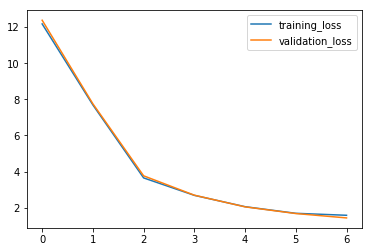

===============epoch:  0 =================
Training loss:  1.29955
Validation loss:  1.23149
Training accuracy:  0.65
Validation accuracy:  0.638095


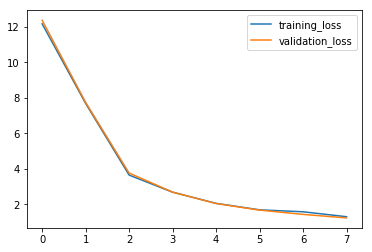

===============epoch:  0 =================
Training loss:  1.13507
Validation loss:  1.11894
Training accuracy:  0.675
Validation accuracy:  0.669524


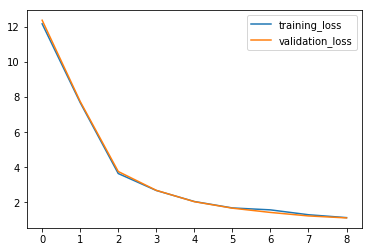

===============epoch:  1 =================
Training loss:  1.1575
Validation loss:  1.00785
Training accuracy:  0.698333
Validation accuracy:  0.702381


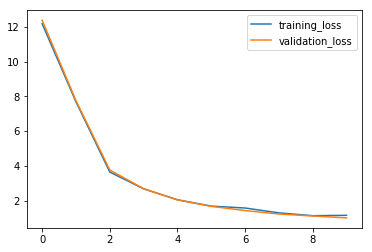

===============epoch:  1 =================
Training loss:  0.906771
Validation loss:  0.92914
Training accuracy:  0.721667
Validation accuracy:  0.721667


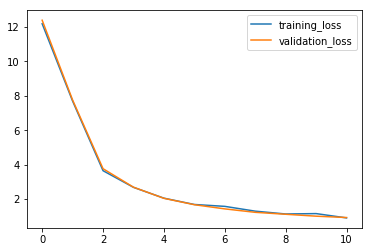

===============epoch:  1 =================
Training loss:  0.788633
Validation loss:  0.842864
Training accuracy:  0.771667
Validation accuracy:  0.749524


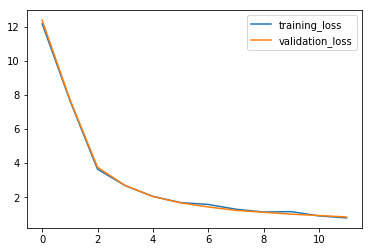

===============epoch:  1 =================
Training loss:  0.778754
Validation loss:  0.783241
Training accuracy:  0.775
Validation accuracy:  0.764524


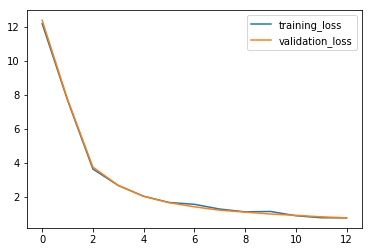

===============epoch:  1 =================
Training loss:  0.794729
Validation loss:  0.723899
Training accuracy:  0.77
Validation accuracy:  0.781905


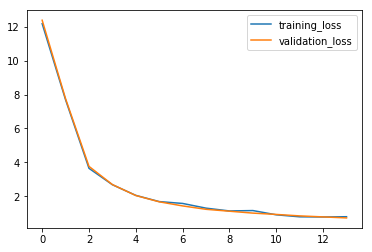

===============epoch:  1 =================
Training loss:  0.680431
Validation loss:  0.677735
Training accuracy:  0.786667
Validation accuracy:  0.799048


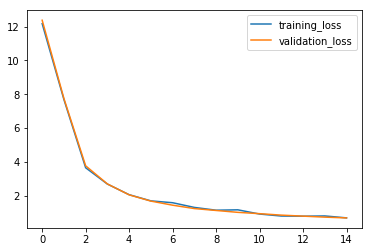

===============epoch:  1 =================
Training loss:  0.70681
Validation loss:  0.637207
Training accuracy:  0.801667
Validation accuracy:  0.809286


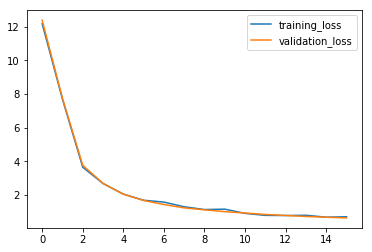

===============epoch:  1 =================
Training loss:  0.643789
Validation loss:  0.598565
Training accuracy:  0.795
Validation accuracy:  0.824048


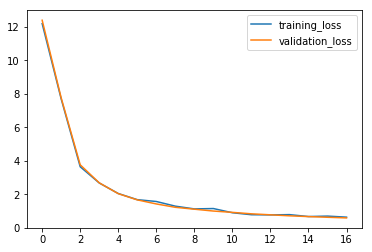

===============epoch:  1 =================
Training loss:  0.559728
Validation loss:  0.558354
Training accuracy:  0.841667
Validation accuracy:  0.835


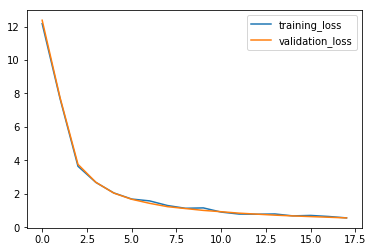

===============epoch:  2 =================
Training loss:  0.65683
Validation loss:  0.530277
Training accuracy:  0.818333
Validation accuracy:  0.847381


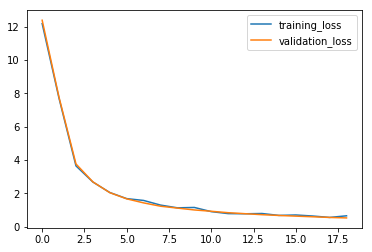

===============epoch:  2 =================
Training loss:  0.481679
Validation loss:  0.511299
Training accuracy:  0.841667
Validation accuracy:  0.855476


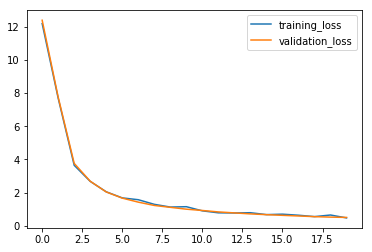

===============epoch:  2 =================
Training loss:  0.408587
Validation loss:  0.481794
Training accuracy:  0.88
Validation accuracy:  0.860238


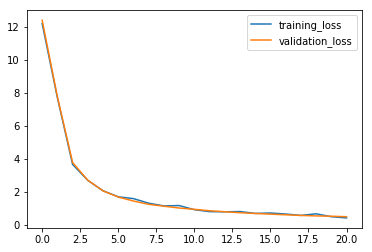

===============epoch:  2 =================
Training loss:  0.443893
Validation loss:  0.464834
Training accuracy:  0.86
Validation accuracy:  0.860238


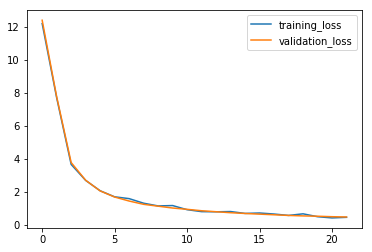

===============epoch:  2 =================
Training loss:  0.474164
Validation loss:  0.441027
Training accuracy:  0.855
Validation accuracy:  0.870714


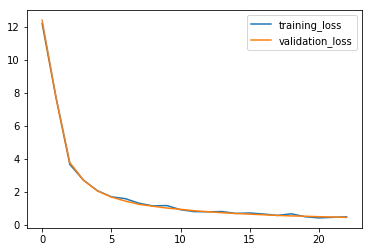

===============epoch:  2 =================
Training loss:  0.394971
Validation loss:  0.42308
Training accuracy:  0.89
Validation accuracy:  0.875476


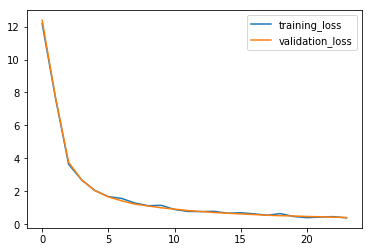

===============epoch:  2 =================
Training loss:  0.43304
Validation loss:  0.408567
Training accuracy:  0.858333
Validation accuracy:  0.879524


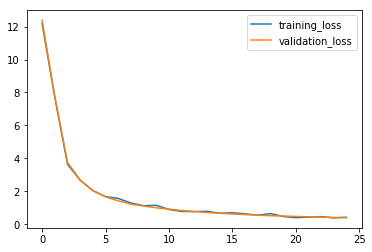

===============epoch:  2 =================
Training loss:  0.387117
Validation loss:  0.397977
Training accuracy:  0.871667
Validation accuracy:  0.883333


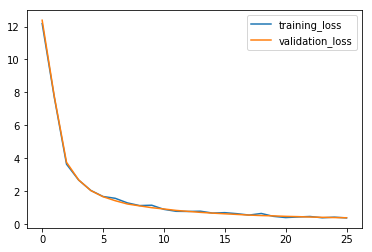

===============epoch:  2 =================
Training loss:  0.353377
Validation loss:  0.379506
Training accuracy:  0.895
Validation accuracy:  0.885952


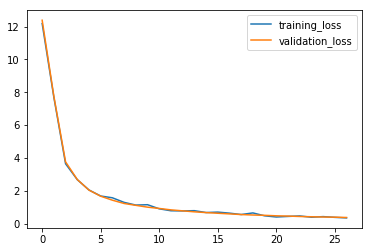

===============epoch:  3 =================
Training loss:  0.434127
Validation loss:  0.367047
Training accuracy:  0.878333
Validation accuracy:  0.892143


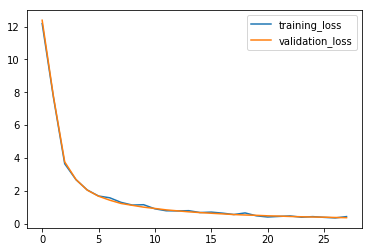

===============epoch:  3 =================
Training loss:  0.312957
Validation loss:  0.363814
Training accuracy:  0.896667
Validation accuracy:  0.893571


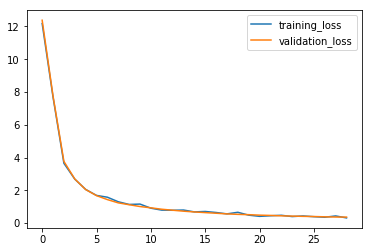

===============epoch:  3 =================
Training loss:  0.27899
Validation loss:  0.345251
Training accuracy:  0.923333
Validation accuracy:  0.895


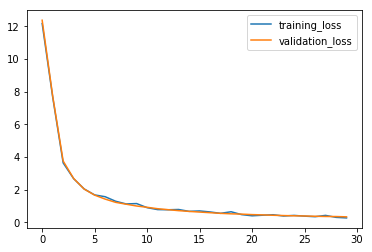

===============epoch:  3 =================
Training loss:  0.308025
Validation loss:  0.334036
Training accuracy:  0.9
Validation accuracy:  0.9


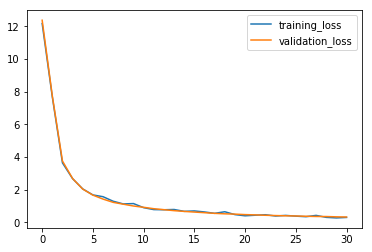

===============epoch:  3 =================
Training loss:  0.345656
Validation loss:  0.324076
Training accuracy:  0.9
Validation accuracy:  0.902143


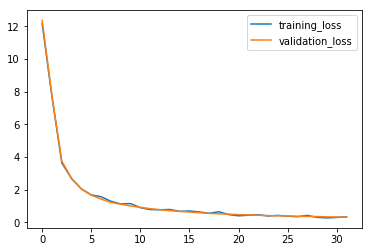

===============epoch:  3 =================
Training loss:  0.282228
Validation loss:  0.313012
Training accuracy:  0.913333
Validation accuracy:  0.905952


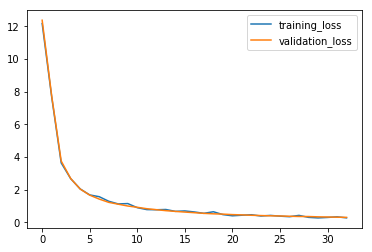

===============epoch:  3 =================
Training loss:  0.296439
Validation loss:  0.308053
Training accuracy:  0.901667
Validation accuracy:  0.90381


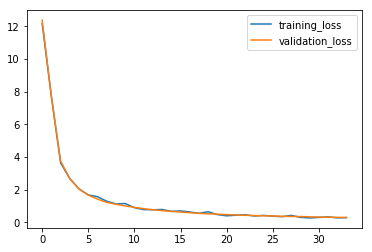

===============epoch:  3 =================
Training loss:  0.27707
Validation loss:  0.300699
Training accuracy:  0.908333
Validation accuracy:  0.907381


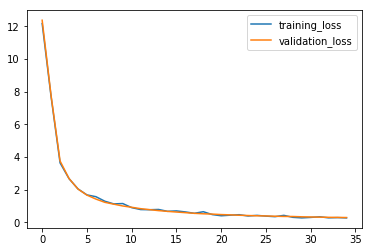

===============epoch:  3 =================
Training loss:  0.26971
Validation loss:  0.287897
Training accuracy:  0.921667
Validation accuracy:  0.913571


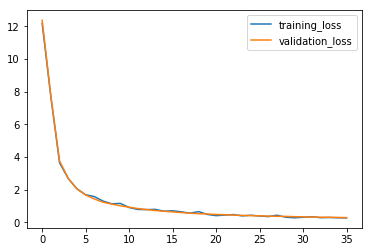

===============epoch:  4 =================
Training loss:  0.296606
Validation loss:  0.282501
Training accuracy:  0.923333
Validation accuracy:  0.915238


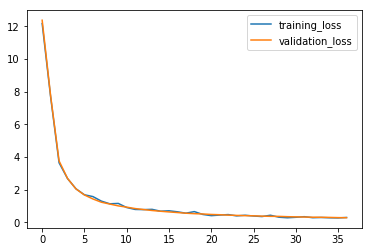

===============epoch:  4 =================
Training loss:  0.22498
Validation loss:  0.280788
Training accuracy:  0.926667
Validation accuracy:  0.916905


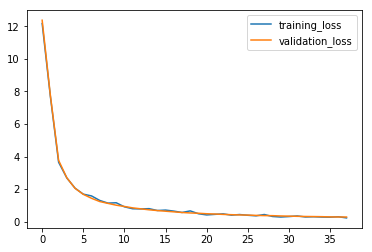

===============epoch:  4 =================
Training loss:  0.205382
Validation loss:  0.272513
Training accuracy:  0.941667
Validation accuracy:  0.917619


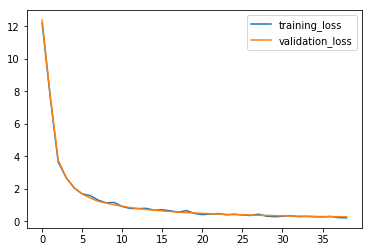

===============epoch:  4 =================
Training loss:  0.222415
Validation loss:  0.261668
Training accuracy:  0.928333
Validation accuracy:  0.925


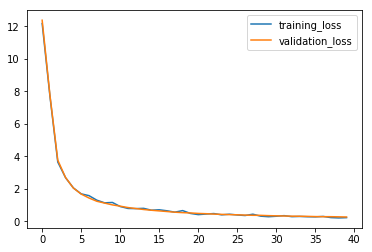

===============epoch:  4 =================
Training loss:  0.265394
Validation loss:  0.259921
Training accuracy:  0.928333
Validation accuracy:  0.925


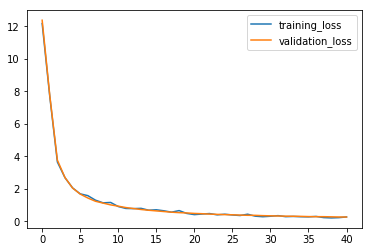

===============epoch:  4 =================
Training loss:  0.213893
Validation loss:  0.247997
Training accuracy:  0.933333
Validation accuracy:  0.925714


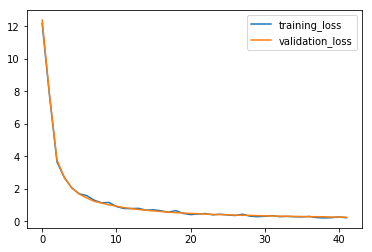

===============epoch:  4 =================
Training loss:  0.228646
Validation loss:  0.24699
Training accuracy:  0.928333
Validation accuracy:  0.927857


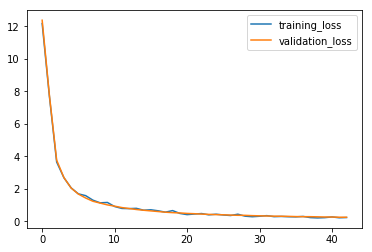

===============epoch:  4 =================
Training loss:  0.226313
Validation loss:  0.240488
Training accuracy:  0.94
Validation accuracy:  0.929286


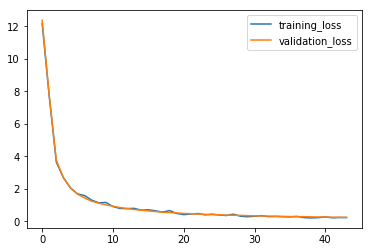

===============epoch:  4 =================
Training loss:  0.228169
Validation loss:  0.232587
Training accuracy:  0.935
Validation accuracy:  0.93


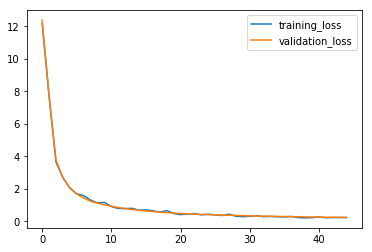

===============epoch:  5 =================
Training loss:  0.220585
Validation loss:  0.232899
Training accuracy:  0.938333
Validation accuracy:  0.929286


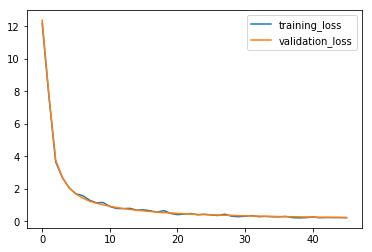

===============epoch:  5 =================
Training loss:  0.187896
Validation loss:  0.231498
Training accuracy:  0.941667
Validation accuracy:  0.931905


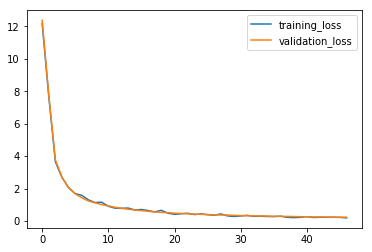

===============epoch:  5 =================
Training loss:  0.166754
Validation loss:  0.230009
Training accuracy:  0.953333
Validation accuracy:  0.930476


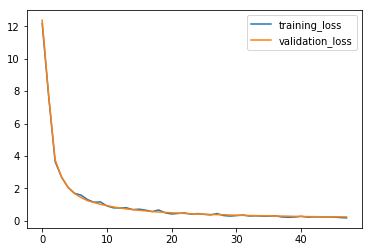

===============epoch:  5 =================
Training loss:  0.179038
Validation loss:  0.218123
Training accuracy:  0.943333
Validation accuracy:  0.934524


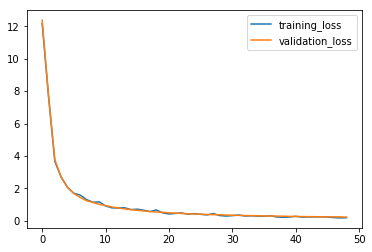

===============epoch:  5 =================
Training loss:  0.211404
Validation loss:  0.218939
Training accuracy:  0.936667
Validation accuracy:  0.935476


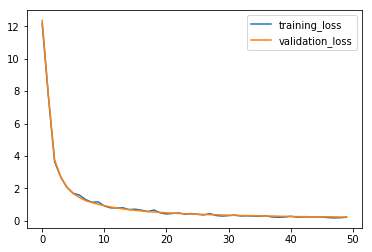

===============epoch:  5 =================
Training loss:  0.178561
Validation loss:  0.211637
Training accuracy:  0.938333
Validation accuracy:  0.936667


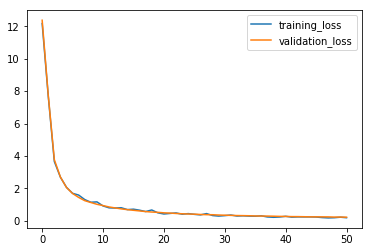

===============epoch:  5 =================
Training loss:  0.186009
Validation loss:  0.211201
Training accuracy:  0.938333
Validation accuracy:  0.937381


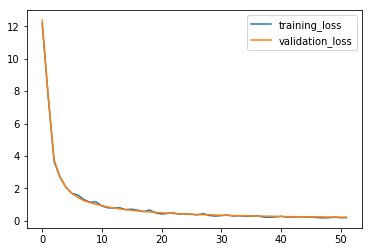

===============epoch:  5 =================
Training loss:  0.195381
Validation loss:  0.205046
Training accuracy:  0.946667
Validation accuracy:  0.940476


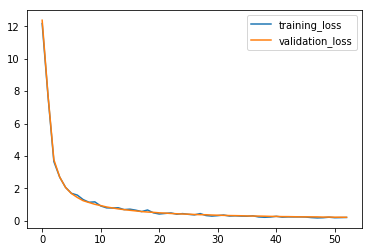

===============epoch:  5 =================
Training loss:  0.20244
Validation loss:  0.200119
Training accuracy:  0.951667
Validation accuracy:  0.940476


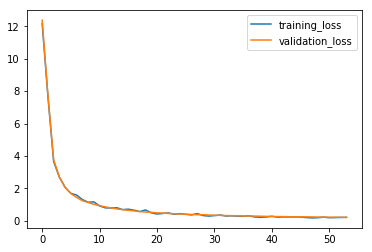

===============epoch:  6 =================
Training loss:  0.159646
Validation loss:  0.200638
Training accuracy:  0.953333
Validation accuracy:  0.939286


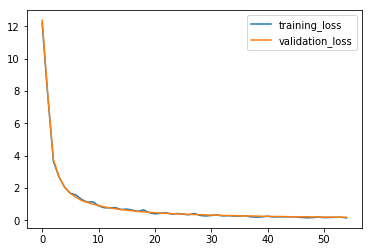

===============epoch:  6 =================
Training loss:  0.157645
Validation loss:  0.200052
Training accuracy:  0.95
Validation accuracy:  0.942857


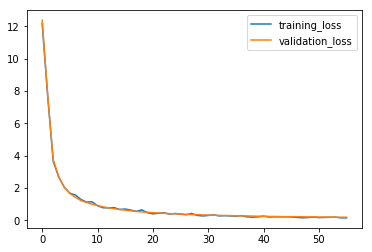

===============epoch:  6 =================
Training loss:  0.134736
Validation loss:  0.198761
Training accuracy:  0.968333
Validation accuracy:  0.938571


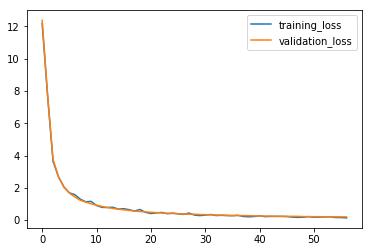

===============epoch:  6 =================
Training loss:  0.153272
Validation loss:  0.18925
Training accuracy:  0.95
Validation accuracy:  0.944762


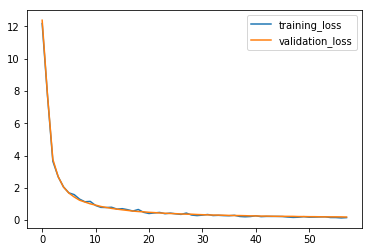

===============epoch:  6 =================
Training loss:  0.180185
Validation loss:  0.191154
Training accuracy:  0.946667
Validation accuracy:  0.943571


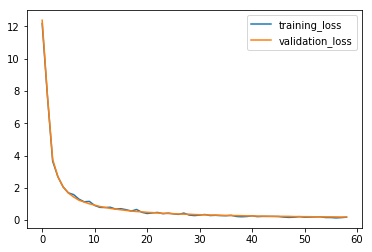

===============epoch:  6 =================
Training loss:  0.152905
Validation loss:  0.18543
Training accuracy:  0.951667
Validation accuracy:  0.943333


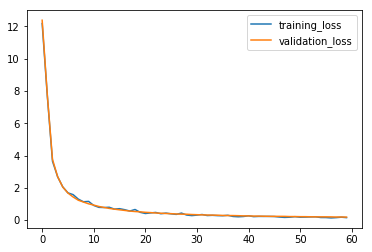

===============epoch:  6 =================
Training loss:  0.153912
Validation loss:  0.184806
Training accuracy:  0.95
Validation accuracy:  0.944762


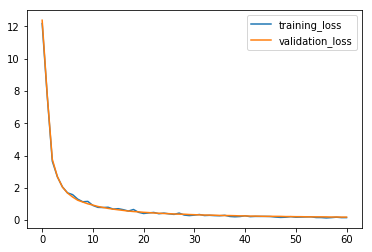

===============epoch:  6 =================
Training loss:  0.173759
Validation loss:  0.180819
Training accuracy:  0.953333
Validation accuracy:  0.946667


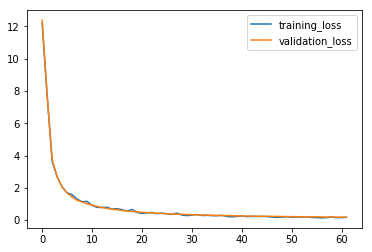

===============epoch:  6 =================
Training loss:  0.183637
Validation loss:  0.177091
Training accuracy:  0.956667
Validation accuracy:  0.94619


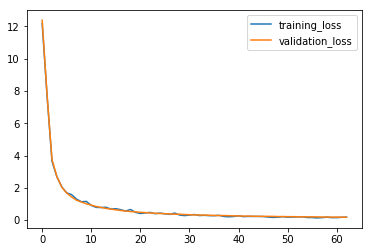

===============epoch:  7 =================
Training loss:  0.128071
Validation loss:  0.177034
Training accuracy:  0.96
Validation accuracy:  0.947857


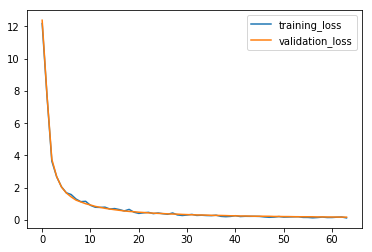

===============epoch:  7 =================
Training loss:  0.135973
Validation loss:  0.176159
Training accuracy:  0.956667
Validation accuracy:  0.948333


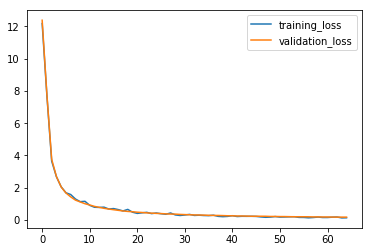

===============epoch:  7 =================
Training loss:  0.113348
Validation loss:  0.177727
Training accuracy:  0.971667
Validation accuracy:  0.947857


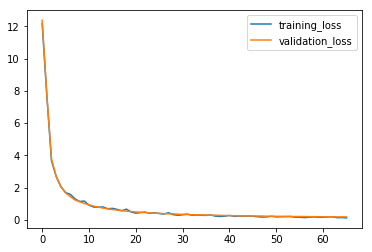

===============epoch:  7 =================
Training loss:  0.139745
Validation loss:  0.168395
Training accuracy:  0.956667
Validation accuracy:  0.948571


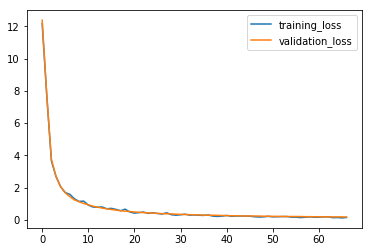

===============epoch:  7 =================
Training loss:  0.157946
Validation loss:  0.168371
Training accuracy:  0.951667
Validation accuracy:  0.949048


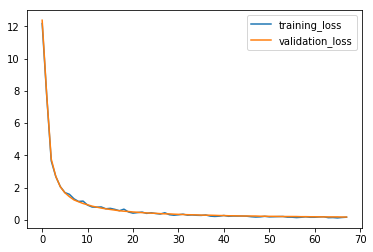

===============epoch:  7 =================
Training loss:  0.136108
Validation loss:  0.166132
Training accuracy:  0.96
Validation accuracy:  0.950714


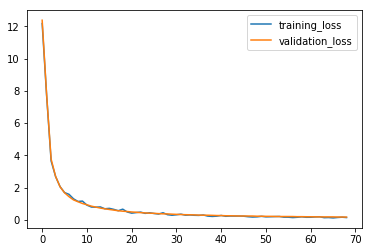

===============epoch:  7 =================
Training loss:  0.131521
Validation loss:  0.164997
Training accuracy:  0.955
Validation accuracy:  0.950952


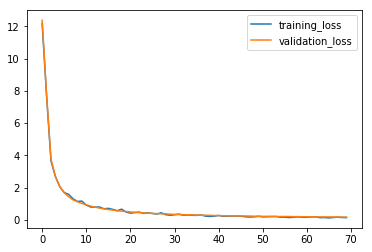

===============epoch:  7 =================
Training loss:  0.153161
Validation loss:  0.163281
Training accuracy:  0.955
Validation accuracy:  0.950476


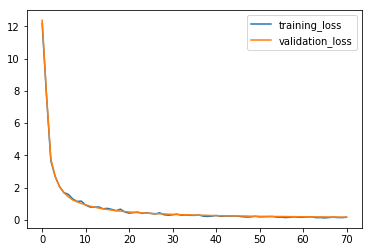

===============epoch:  7 =================
Training loss:  0.1674
Validation loss:  0.160477
Training accuracy:  0.958333
Validation accuracy:  0.952143


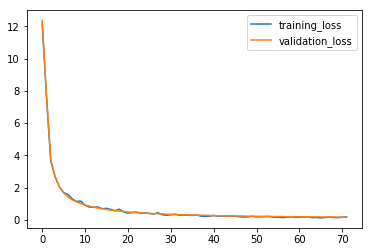

In [32]:
run_model(8, images, labels, 600, 0.3)

In [95]:
##############################################################
#                Part Five: Testing 
##############################################################

In [ ]:
test_images = []

with open('test.csv') as test_file:
    # Skip first line.
    test_file.readline()
    
    csv_test_file = csv.reader(test_file, delimiter=',')
    for row in csv_test_file:
        test_images.append(np.array(row, dtype=float))

In [ ]:
t_offset = 1

with open('test_output.csv', 'w') as test_output:
    test_output.write('ImageId,Label\n')
    
    test_loader = BatchLoader(test_images)

    
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        loaded_image_tensor = loaded_graph.get_tensor_by_name("conv_input:0")
        loaded_label_tensor = loaded_graph.get_tensor_by_name("conv_label:0")
        loaded_dropout_prob = loaded_graph.get_tensor_by_name("dropout_prob:0")
        loaded_logits = loaded_graph.get_tensor_by_name("logits:0")
    
        while True:
            test_image_batch = test_loader.load_batch_image(600)
            
            if len(test_image_batch) == 0:
                break
            
            labels = sess.run(loaded_logits, feed_dict={
                loaded_image_tensor: test_image_batch,
                loaded_dropout_prob: 0.0
            })
        
            labels = np.argmax(labels, axis=1)
        
            data = zip(range(t_offset, t_offset + len(labels)), labels)
        
            for d in data:
                test_output.write('%d,%d\n' % d)
            
            t_offset += len(labels)
        

INFO:tensorflow:Restoring parameters from ./kaggle_digit
